In [2]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# Read dataset file
df = pd.read_csv('ETH.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df

,Price
0,693.28
1,696.76
2,716.02
3,696.85
4,642.17
...,...
1822,1799.36
1823,1817.11
1824,1823.98
1825,1821.73


In [11]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

RationalQuadratic: This kernel combines components of the RBF (Radial Basis Function) kernel and includes a linear component as well. It is suitable for modeling patterns that exhibit complex non-uniform or non-periodic behavior in time series data.

In [13]:
#Holt-Winters Exponential Smoothing model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Define the kernel
kernel =RationalQuadratic(length_scale=1.0, alpha=0.1) 
# RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))


# Define the model
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)

# Train the model
model.fit(x_train, y_train)

GaussianProcessRegressor(alpha=0.1,
                         kernel=RationalQuadratic(alpha=0.1, length_scale=1),
                         normalize_y=True)

In [14]:
# make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred, y_std = model.predict(x_test, return_std=True)

# make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_vpred, y_vstd = model.predict(x_val, return_std=True)

In [15]:
# Forecast the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days, y_next_30_day_std = model.predict(x_next_30_days, return_std=True)

# Print the predicted closing prices for the next 30 days
print('Predicted Bitcoin closing prices for the next 30 days:')
y_next_30_days

Predicted Bitcoin closing prices for the next 30 days:


array([1651.70460191, 1650.69214605, 1649.68271742, 1648.67630208,
       1647.67288621, 1646.67245603, 1645.67499788, 1644.68049817,
       1643.6889434 , 1642.70032014, 1641.71461506, 1640.73181491,
       1639.75190651, 1638.77487677, 1637.80071267, 1636.8294013 ,
       1635.86092978, 1634.89528536, 1633.93245532, 1632.97242706,
       1632.01518802, 1631.06072574, 1630.10902784, 1629.16008198,
       1628.21387594, 1627.27039754, 1626.32963468, 1625.39157535,
       1624.45620759, 1623.52351952])

In [16]:
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAPE:", test_mape)

Validation RMSE: 386.27027267876696
Testing RMSE: 604.3991086327821
Validation MAPE: 22.769511484097755
Testing MAPE: 31.112557121047985
Validation MAE: 313.07753666858724
Testing MAPE: 31.112557121047985


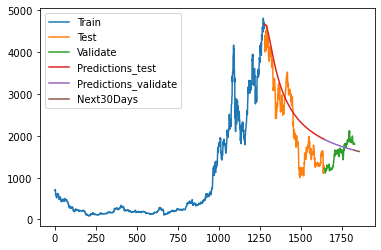

In [18]:
# ploting the actual values and predicted values
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_vpred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test','Validate', 'Predictions_test','Predictions_validate','Next30Days'])
plt.show()